In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.signal import peak_widths
from scipy.integrate import simps

%matplotlib inline

Подгружаем данные

In [2]:
df = pd.read_csv('data/ExpDat_SK_Clear_resin_entalp5kpm_20-150.txt', sep='\t',comment='#')
df.columns = ['Temp', 'Time', 'DSC', 'Sence']

df.head()

,Temp,Time,DSC,Sence
0,20.01794,0.01,0.022839,3.36733
1,20.01857,0.02,0.022820,3.36733
2,20.02401,0.03,0.022770,3.36734
3,20.03631,0.04,0.022824,3.36735
4,20.05572,0.05,0.023849,3.36737


Text(0.5, 1.0, 'Raw cure kinetics signal by temperature')

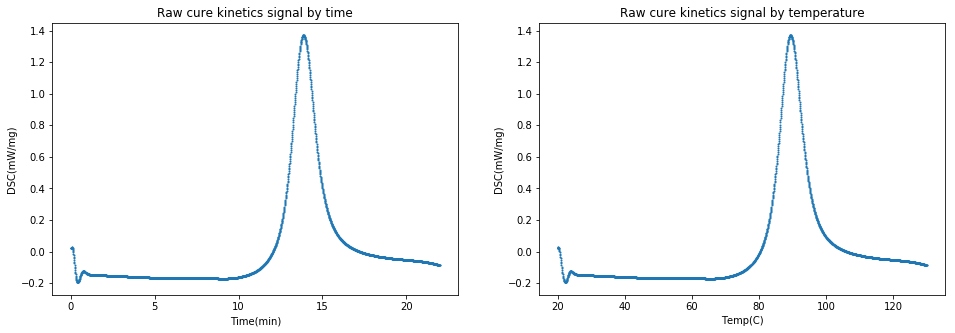

In [3]:
fig, ax = plt.subplots(1, 2, figsize = (16, 5))

ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].plot(df['Time'], df['DSC'], "o", markersize=1)
ax[0].set_title('Raw cure kinetics signal by time')

ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1)
ax[1].set_title('Raw cure kinetics signal by temperature')

### Тут ищем точки начала и конца реакции

Давай по искать точки начала и конца пика по температуре - так будет удобнее. На этом графике он будет где-то от 60 до 110. Вообще отделюную часть кода нужно уделить определению точек начала и конца. Я пытался сделать это автоматически красиво, но получилось так себе. Наверное лучше составить отдельную таблицу и захардкодить.

[0.03235397, 0.02998976]


Text(0.5, 1.0, 'Raw cure kinetics signal by temperature')

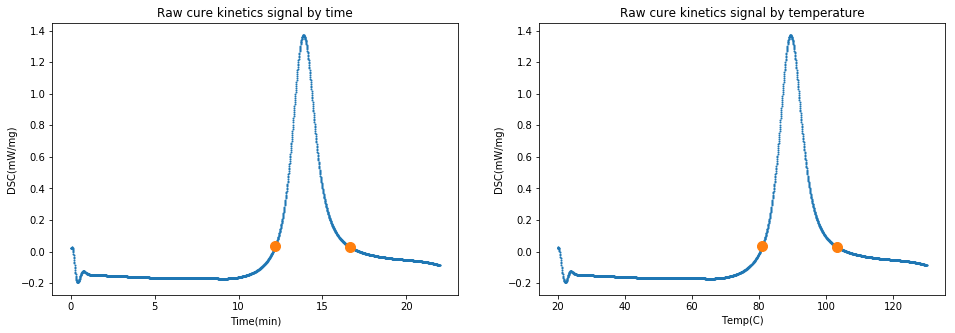

In [4]:
peaks_positive, _ = find_peaks(df['DSC'], height=1.2)
peaks_width, width_heights, _, _ = peak_widths(df['DSC'], peaks_positive, rel_height = 0.92)

peak_start = df['DSC'][df['DSC']>width_heights[0]].first_valid_index()
peak_end = df['DSC'][df['DSC']>width_heights[0]].last_valid_index()


print([df['DSC'][peak_start],df['DSC'][peak_end]])

fig, ax = plt.subplots(1, 2, figsize = (16, 5))


ax[0].plot(df['Time'], df['DSC'], "o", markersize=1, label = "Signal")
ax[0].plot([df['Time'][peak_start],df['Time'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
              "o", markersize=10, label = "Baseline")
ax[0].set_xlabel("Time(min)")
ax[0].set_ylabel('DSC(mW/mg)')
ax[0].set_title('Raw cure kinetics signal by time')

ax[1].plot(df['Temp'], df['DSC'], "o", markersize=1, label = "Signal")
ax[1].plot([df['Temp'][peak_start],df['Temp'][peak_end]],
               [df['DSC'][peak_start],df['DSC'][peak_end]],
                "o", markersize=10, label = "Baseline")
ax[1].set_xlabel("Temp(C)")
ax[1].set_ylabel('DSC(mW/mg)')
ax[1].set_title('Raw cure kinetics signal by temperature')

#TODO add legend on plots

Строим бейслайн по точкам начала и конца, режем пик, приводим к бейслайну

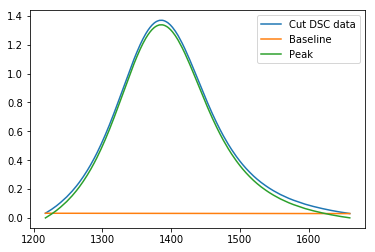

In [5]:
baseline = np.zeros(0)

for i in range(peak_end - peak_start):  # строим baseline
    new_val = (df['DSC'][peak_end] - df['DSC'][peak_start])/(peak_end - peak_start)*i + df['DSC'][peak_start]
    baseline = np.append(baseline,new_val)

peak = df['DSC'][peak_start: peak_end] - baseline
        
plt.plot(df['DSC'][peak_start: peak_end], label = "Cut DSC data")
plt.plot(range(peak_start, peak_end), baseline, label = "Baseline")
plt.plot(range(peak_start, peak_end), peak, label = "Peak")
plt.legend()

По приведенному к бейслайну пику строим альфу - степень полимеризации

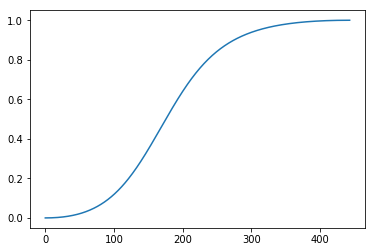

In [6]:
spent_energy = simps(peak)
alpha = []
    
for i,_ in enumerate(peak):
    alpha.append(simps(peak[:i+1])/spent_energy)
plt.plot(alpha)

Наверное тут стоит начать создавать датафрейм, где будет только только пик + добавить к нему колонку альфы и $\frac{d\alpha}{dt}$

In [17]:
dt = []
dalpha = []
dalpha_dt = []
temp = []
dtemp = []
dalpha_dtemp = []

for i in range(peak_end - peak_start):
    dt.append((df['Time'][i+1] - df['Time'][i]) * 60)
    temp.append(df['Temp'][i] + 237)
    dtemp.append(df['Temp'][i+1] - df['Temp'][i])

dalpha.append(0)
for i in range(len(alpha)-1):
    dalpha.append(alpha[i+1] - alpha[i])

for i in range(len(dalpha)):
    dalpha_dt.append(dalpha[i]/dt[i])
    
for i in range(len(dalpha)):
    dalpha_dtemp.append(dalpha[i]/dtemp[i])
    
data = {'alpha' : alpha, 
        'dtime' : dt, 
        'dalpha' : dalpha, 
        'dalpha_dtime' : dalpha_dt, 
        'time' : df['Time'][peak_start:peak_end], 
        'peak' : peak,
        'temp' : temp,
        'dtemp' : dtemp,#разве что как фича для новых регрессий
        'dalpha_dtemp' : dalpha_dtemp,
       }

processed_df = pd.DataFrame(data, columns = ['alpha', 'dtime', 'dalpha', 'dalpha_dtime', 'time', 'peak', 'temp', 'dtemp', 'dalpha_dtemp'])
processed_df.drop(processed_df.head(1).index, inplace=True)
processed_df.drop(processed_df.tail(1).index, inplace=True)
processed_df.head()
#processed_df.tail()

,alpha,dtime,dalpha,dalpha_dtime,time,peak,temp,dtemp,dalpha_dtemp
1218,0.000007,0.6,0.000007,0.000011,12.19,0.002945,257.01857,0.00544,0.001226
1219,0.000027,0.6,0.000020,0.000033,12.20,0.005797,257.02401,0.01230,0.001615
1220,0.000059,0.6,0.000033,0.000054,12.21,0.008634,257.03631,0.01941,0.001682
1221,0.000105,0.6,0.000046,0.000076,12.22,0.011537,257.05572,0.02649,0.001723
1222,0.000164,0.6,0.000059,0.000098,12.23,0.014431,257.08221,0.03327,0.001767


$$\frac{d\alpha}{dt} = Ae^{-\frac{E_a}{RT}}(1-\alpha)^n \alpha^m$$
$$\ln(\frac{d\alpha}{dt}) = \ln(A) + \frac{E_a}{RT} + n \ln(1-\alpha) + m \ln(\alpha)$$

In [70]:
from sklearn import linear_model

R = 8.314

a = np.ones(processed_df['alpha'].count()) #собираем матрицу коэффицентов
b = np.array(-1 / (R * processed_df['temp']))
c = np.array(np.log(1 - processed_df['alpha']))
d = np.log(processed_df['alpha'])
X = np.vstack([a, b, c, d])
#X = np.vstack([a, b, c])
X = X.transpose()


y = np.log(processed_df['dalpha_dtime'])

lm_regr = linear_model.LinearRegression(fit_intercept=False, normalize=True)
lm_regr.fit(X, y)

lm_regr.coef_

array([-3.43746187e+01, -6.73725693e+04,  5.23221539e-01,  7.80989816e-01])

In [71]:
print(processed_df.iloc[0, 1])

0.5999999999999999


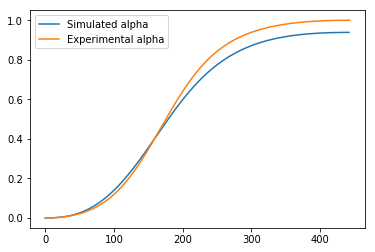

In [72]:
A = np.exp(lm_regr.coef_[0])

processed_df["pred_dalpha_dtime"] =  np.exp(lm_regr.predict(X))

pred_alpha = []
pred_alpha.append(0)
for i in range(len(processed_df)):
    pred_alpha.append(pred_alpha[-1] + 
                      processed_df.iloc[i][-1]*processed_df.iloc[i][1])


plt.plot(pred_alpha, label = "Simulated alpha")
plt.plot(alpha, label = "Experimental alpha")
plt.legend()